# Setup

We install python 3.8 as the version to test the binned atributte in the zfit library in its latest unstable version

In [1]:
! python --version

Python 3.8.13


In [2]:
# ! pip3 install hist

In [3]:
# Install the cutting edge (unstable) version of zfit

# ! pip install git+https://github.com/zfit/zfit

In [4]:
import hist as hist
import mplhep
import numpy as np
import zfit
import zfit.z.numpy as znp

/home/carlos/anaconda3/envs/zfit_latest/lib/python3.8/site-packages/zfit/__init__.py:50: UserWarning: This is an ALPHA version of zfit for feature testing, do NOT use it in production! It is NOT stable and contains bugs and untested features. For production use, please use the last beta stable version of zfit.
  warnings.warn(
/home/carlos/anaconda3/envs/zfit_latest/lib/python3.8/site-packages/zfit/__init__.py:62: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [5]:
zfit.__version__

'0.9.0a3.dev59+g5b1848fc'

In [6]:
from matplotlib import pyplot as plt

# Binned fits

Models and data are binned in two ways
- Unbinned model -> binned model; unbinned dataset -> binned dataset
- Directly from a binned object

In [7]:
size_sampler = 100000

In [8]:
# We want to use the sample data directly generated from the model, so
# we skip this line in the tutorial

# normal_np = np.random.normal(loc=2., scale=3., size=10000)


#Observable space
obs = zfit.Space("x", limits=(-10, 10))

#Parameters
mu = zfit.Parameter("mu", 1., -4, 6)
sigma = zfit.Parameter("sigma", 1., 0.1, 10)
model_nobin = zfit.pdf.Gauss(mu, sigma, obs)

#Creating sample data
sampler = model_nobin.create_sampler(size_sampler)

#Resample
sampler.resample()

# data_nobin = zfit.Data.from_numpy(obs, sampler)

loss_nobin = zfit.loss.UnbinnedNLL(model_nobin, sampler)

In [9]:
# make binned, this just works with the latest version, even 0.8.3 (stable)
# doesen't have this feature yet
binning = zfit.binned.RegularBinning(50, -8, 10, name="x")
obs_bin = zfit.Space("x", binning=binning)

# the same goes for the method .to_binned(...) in zfit-type data
# change data_nobin -> sampler
data = sampler.to_binned(obs_bin)

# Second form to create a binned model: and BinnedFrom UnbinnedPDF(...)
model = zfit.pdf.BinnedFromUnbinnedPDF(model_nobin, obs_bin)
loss = zfit.loss.BinnedNLL(model, data)

# Minimization

It is the same for binned and unbinned data:

In [10]:
#Minimization works the same for binned and unbinned data
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(loss)

In [11]:
# .hesse() returns a warning about accessing the error to 'hesse' instead of
# 'hesse_np' or 'minuit_hesse'. This is the new zfit implementation that didn't
# exist in 0.5.3
result.hesse()
print(result)

/home/carlos/anaconda3/envs/zfit_latest/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1170: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7fe82c6e9460>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7fe74ab44e80>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.1e-05 │ -806022.4   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name          hesse     value    at limit
------  -----------  --------  ----------
mu      +/-  0.0032  0.993258       False
sigma   +/-  0.0023   1.00307       False


# Plotting the PDF

PDFs that are histograms can be converted to histograms in plotting. Using `to_hist` method of the model and `BinnedData` respectively, data can be converted to a histogram

In [12]:
import tensorflow as tf
from zfit import z

In [13]:
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(loss_nobin)

In [14]:
result.hesse()
print(result)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.core.data.Sampler object at 0x7fe74a8f8880>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.7e-09 │ 996.7424    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name          hesse     value    at limit
------  -----------  --------  ----------
mu      +/-  0.0032  0.992913       False
sigma   +/-  0.0022   1.00273       False


In [15]:
def plot_model(model, data, scale=1, plot_data=True):  # we will use scale later on

    nbins = 50

    lower, upper = data.data_range.limit1d
    x = tf.linspace(lower, upper, num=1000)  # np.linspace also works
    y = model.pdf(x) * size_sampler / nbins * data.data_range.area()
    y *= scale
    plt.plot(x, y)
    data_plot = zfit.run(z.unstack_x(data))  # we could also use the `to_pandas` method
    if plot_data:
        plt.hist(data_plot, bins=nbins)

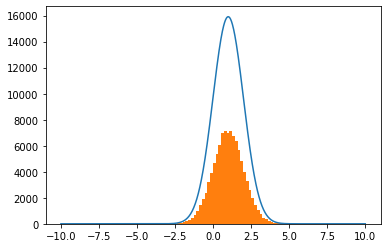

In [16]:
#Graficación de datos bineados y modelo sin minimizar ni binnear
plot_model(model_nobin, sampler)

Text(0.5, 1.0, 'After fit')

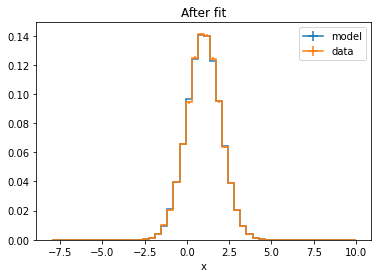

In [17]:
model_hist = model.to_hist()

plt.figure()
mplhep.histplot(model_hist, density=1, label="model")
mplhep.histplot(data.to_hist(), density=1, label="data")
plt.legend()
plt.title("After fit")

# To and from histograms

Scikit-HEP has histogram packages that zfit uses, in particular:
- `NamedHist`
- `Hist` if the axes have a name

We can create BinnedData from an Histogram and vice versa

`BinnedData` <-> `(Named)Hist`

In [18]:
# the array that the histogram instance h.fill receives has to be of this form
normal_np = np.random.normal(loc=2., scale=3., size=10000)
normal_np
#but since we didn't use the numpy generated data, we have to convert the sampler

array([ 0.70131185,  0.52159161,  2.9041696 , ...,  1.54754597,
        3.8443344 , -0.56747348])

In [19]:
# whilst the sampler.numpy() returns an array of the form
sampler.numpy()
#.we have to use .flatten is to remove the 2D to convert to a 1D array 

array([[2.02960538],
       [2.31512941],
       [1.72184593],
       ...,
       [2.26229922],
       [2.20699475],
       [1.12031272]])

Creating an histogram from the sampler data previously generated

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fe6d7195e20>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

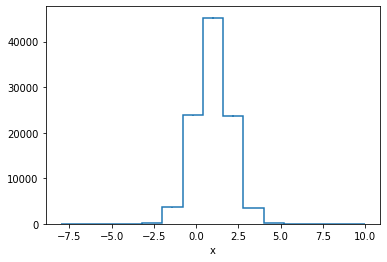

In [20]:
h = hist.Hist(hist.axis.Regular(bins=15, start=-8, stop=10, name="x"))
# h.fill(x=normal_np)
# change normal_np -> sampler.to_numpy().flatten()
h.fill(x=sampler.numpy().flatten())
mplhep.histplot(h)

In [21]:
h.counts()

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.2500e+02,
       3.5920e+03, 2.3824e+04, 4.5245e+04, 2.3638e+04, 3.4450e+03,
       1.2600e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

Creating Binned data from an Histogram

In [22]:
binned_data = zfit.data.BinnedData.from_hist(h)
binned_data

In [23]:
binned_data.counts()

<tf.Tensor: shape=(15,), dtype=float64, numpy=
array([0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.2500e+02,
       3.5920e+03, 2.3824e+04, 4.5245e+04, 2.3638e+04, 3.4450e+03,
       1.2600e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])>

Converting back from a BinnedData to a histogram

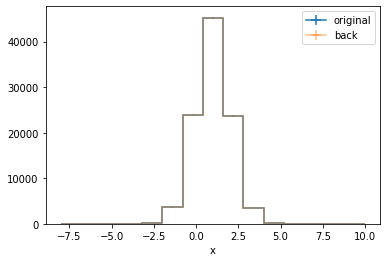

In [24]:
# convert back to hist
h_back = binned_data.to_hist()

plt.figure()
mplhep.histplot(h, label="original")
mplhep.histplot(h_back, label="back", alpha=0.5)
plt.legend()

In [25]:
h_back.counts()

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.2500e+02,
       3.5920e+03, 2.3824e+04, 4.5245e+04, 2.3638e+04, 3.4450e+03,
       1.2600e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

# Binned models from histograms

`HistogramPDF`: create a histogram &rarr; binned dataset &rarr; binned model

In [26]:
histpdf = zfit.pdf.HistogramPDF(h)

Methods of the BinnedPDF:

- `to_hist`: get a `(Named)Hist` from the model
- `to_binned`: get a BinnedData from the model
- `counts`: Get counts of the histogram
- `rel_counts`: Get relative counts of the histogram
- `ext_pdf`: ?

In [27]:
histpdf.pdf(binned_data)

<tf.Tensor: shape=(15,), dtype=float64, numpy=
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.66666667e-05,
       1.04166667e-03, 2.99333333e-02, 1.98533333e-01, 3.77041667e-01,
       1.96983333e-01, 2.87083333e-02, 1.05000000e-03, 2.50000000e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])>

In [28]:
#what is the difference between a ext_pdf and a pdf?
histpdf.ext_pdf(binned_data) 

<tf.Tensor: shape=(15,), dtype=float64, numpy=
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.66666667e+00,
       1.04166667e+02, 2.99333333e+03, 1.98533333e+04, 3.77041667e+04,
       1.96983333e+04, 2.87083333e+03, 1.05000000e+02, 2.50000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])>

> What is the difference between .pdf and .ext_pdf ?

/home/carlos/anaconda3/envs/zfit_latest/lib/python3.8/site-packages/zfit/core/binning.py:88: UserWarning: Flow currently not fully supported. Values outside the edges are all 0.
  warnings.warn(


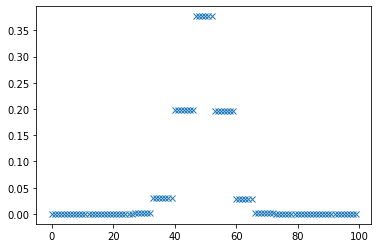

In [29]:
x = znp.linspace(-8, 10, 100)
plt.plot(histpdf.pdf(x), 'x')

`HistogramPDF` &rarr; `Hist`, two ways to do it:

- Using the methods `to_hist` or `to_binneddata` method of `HistogramPDF` to create `Hist` or `BinnedData`
- Sampling the histogram with the method `sample`. (No exact match, will have random fluctuations, can be used to perform toy studies)

In [30]:
azimov_hist = model.to_hist()
azimov_data= model.to_binneddata()
sampled_data = model.sample(size_sampler)

In [31]:
# Exact histogram from the PDF
azimov_data

In [32]:
# A sample from the histogram
sampled_data